In [1]:
%matplotlib inline
# %matplotlib qt
# import mpld3
# mpld3.enable_notebook() # seems to just freeze the stuff a bit
# import matplotlib
# matplotlib.use('nbagg') # also slow AF

In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib

In [3]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2

In [4]:
import pywt
import pyhht

In [5]:
from imp import reload
import auxfilter
import glob

In [38]:
# os.chdir('..')
os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics

/home/mike/venvs/ml/ml/py


In [7]:
reload(plotstuff)

<module 'eegkaggle.plotting.plotstuff' from 'eegkaggle/plotting/plotstuff.pyc'>

In [8]:
matplotlib.style.use('ggplot')

In [9]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slong

Functions

In [10]:
# this needs to be here because...reasons?
def pltcwt(plt, my_cwt, widths, realize=None):
    hi = np.max(widths)
    lo = np.min(widths)
    if realize == 'abs':
        my_cwt = np.abs(my_cwt)
    elif realize == 'ang':
        my_cwt = np.angle(my_cwt)
    plt.imshow(my_cwt, extent=[-1, 1, hi, lo], cmap='seismic', aspect='auto',
               vmax=abs(my_cwt).max(), vmin=-abs(my_cwt).max())


def plt_easycwt(plt, sig, widths):
    my_cwt = signal.cwt(sig, signal.ricker, widths)
    pltcwt(plt, my_cwt, widths)

Data loading section

In [11]:
basepath = '/home/mike/Downloads/train_1/'
path = basepath + '1_1_1.mat'
rawdata = dataio.get_matlab_eeg_data(path)
data = rawdata['data']
print(data.shape)
SR = rawdata['iEEGsamplingRate'][0][0]
if SR == int(SR):
    SR = int(SR)
print(SR)

(240000, 16)
400


In [12]:
brief = data[:SR*120]
brief.shape

(48000, 16)

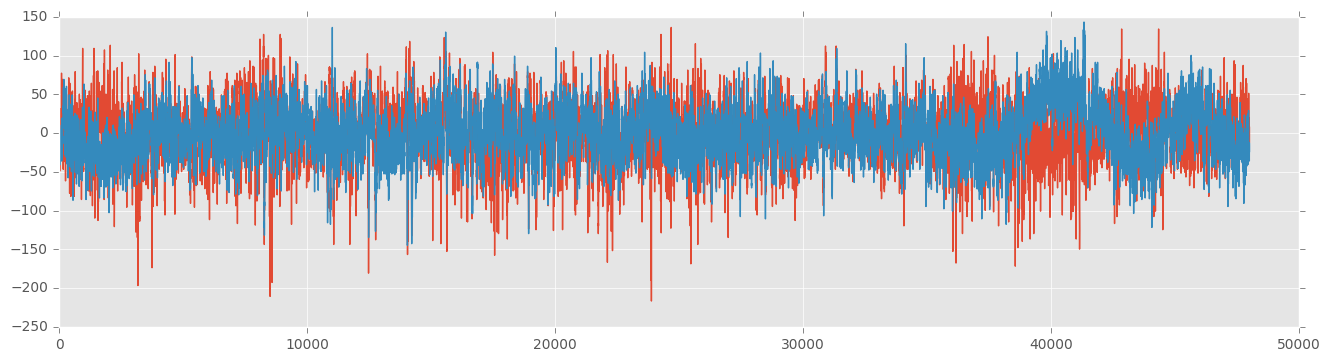

In [13]:
plt.plot(brief[:,:2])

In [14]:
eeg1 = brief[:,0]
eeg2 = brief[:,1]

In [15]:
lo, hi = 1, 16
nbins = 32
widths = np.linspace(lo, hi, nbins)**2

In [16]:
data.shape

(240000, 16)

In [17]:
sig = data[:, 0]
fsig = ftpk.fft(data, axis=0)
t = np.linspace(0, 400, len(fsig))

fsig.shape


(240000, 16)

/home/mike/venvs/ml/ml/local/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


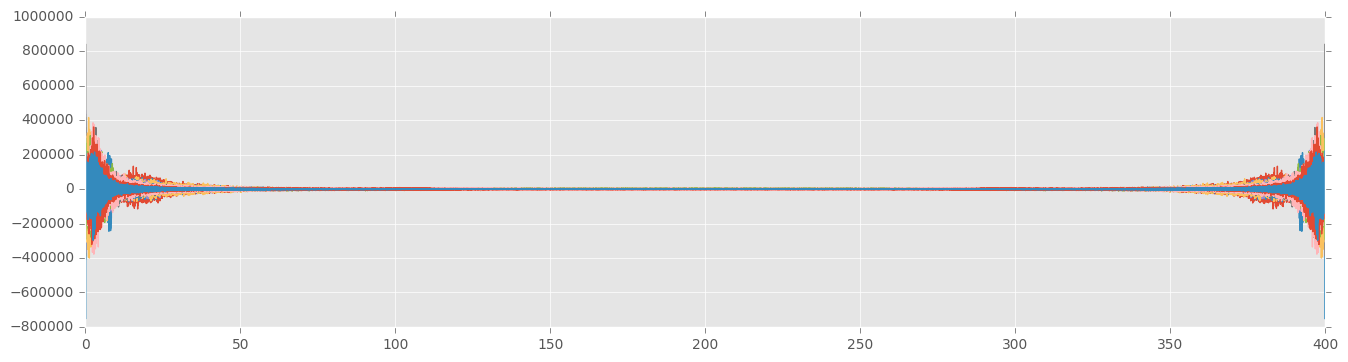

In [18]:
plt.plot(np.linspace(0, 400, len(fsig)), fsig)

In [19]:
sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 


In [20]:
limit = 20
dataset0 = [ dataio.get_matlab_eeg_data(path)['data'] for path in sources0[:limit]]
dataset1 = [ dataio.get_matlab_eeg_data(path)['data'] for path in sources1[:limit]]


In [21]:
dataset0[0].shape

(240000, 16)

In [22]:
d0 = dataio.get_matlab_eeg_data('/home/mike/Downloads/train_1/1_102_0.mat')['data']
d1 = dataio.get_matlab_eeg_data('/home/mike/Downloads/train_1/1_102_1.mat')['data']

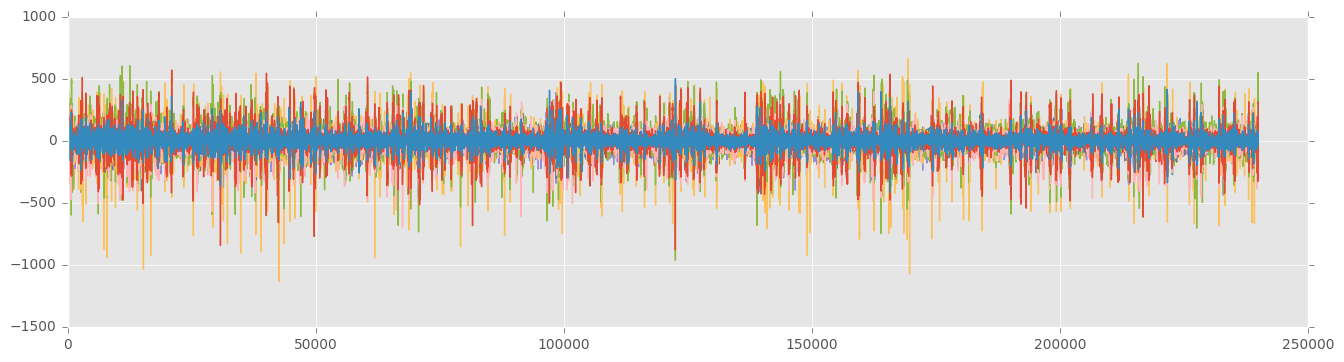

In [23]:
plt.plot(d0)

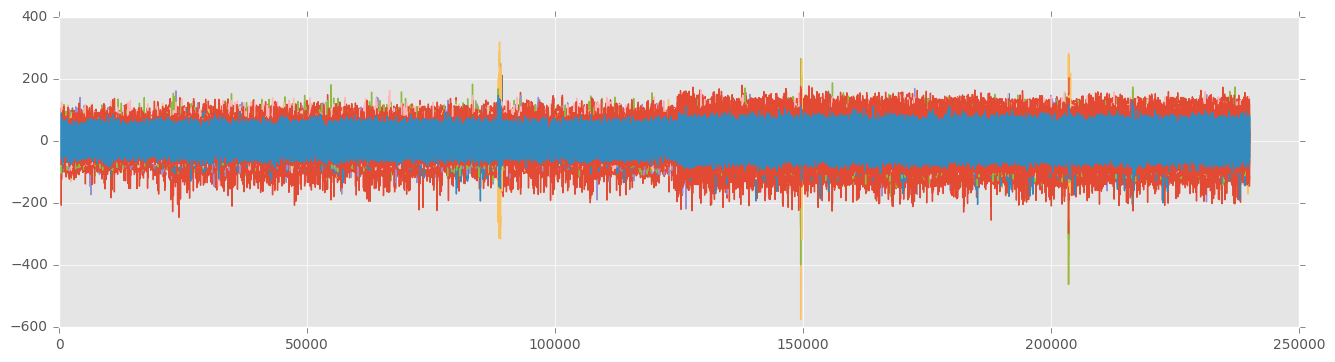

In [24]:
plt.plot(d1)

In [25]:
fsig0 = ftpk.fft(d0, axis=0)
t = np.linspace(0, 400, len(fsig0), endpoint=False)
cutoff = 40
cutidx = np.where(t == cutoff)[0][0]
fsig0 = fsig0[:cutidx]
t = t[:cutidx]

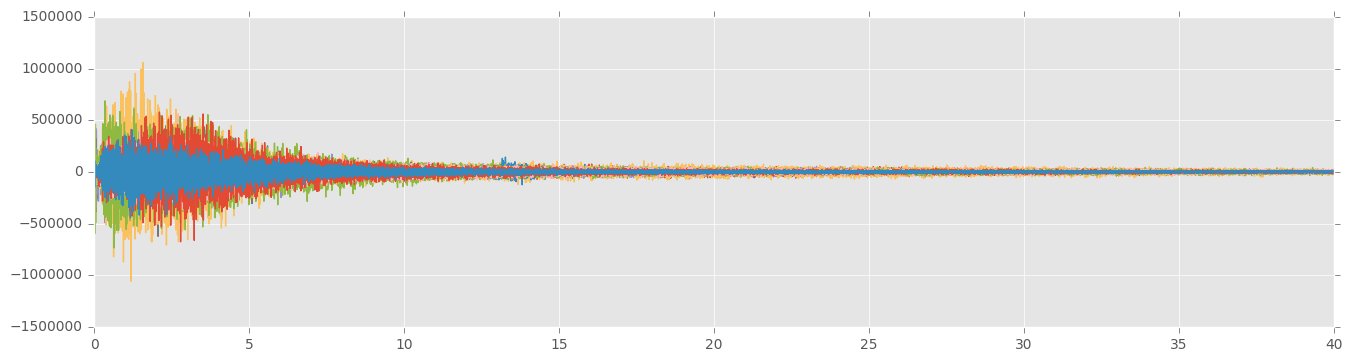

In [26]:
plt.plot(t, fsig0)
plt.show()

(240000, 16)
  (3750, 64, 16)


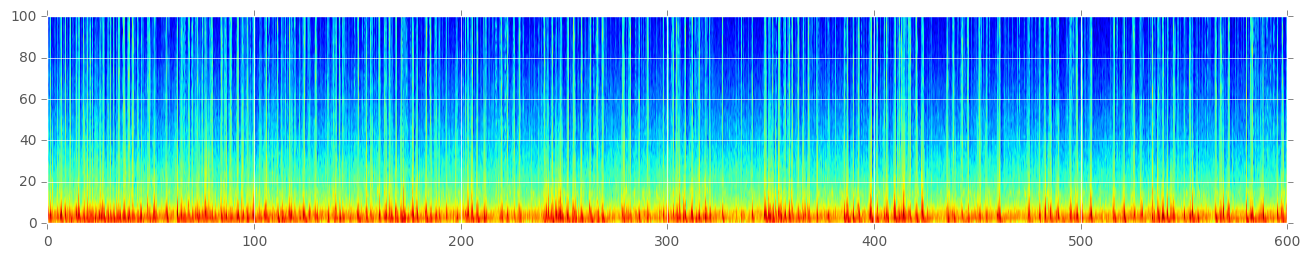

In [27]:
reload(spectral)
nchunk = 256
windowStep = 4
print(d0.shape)
spec = spectral.spectrogram(d0, nchunk=nchunk, windowStep=windowStep, absLog=1, alpha=0.5, window='hann')

print(' ', spec.shape)

# plt.imshow(np.average(spec[:,:], axis=2).T, origin='lower', extent=[0, 600, 0, 100])
spectral.spec_to_fig(spec, 'd0.png')

eegkaggle/vectorizers/spectral.py:75: RuntimeWarning: divide by zero encountered in log
  spec_ary = np.log(np.abs(spec_ary))


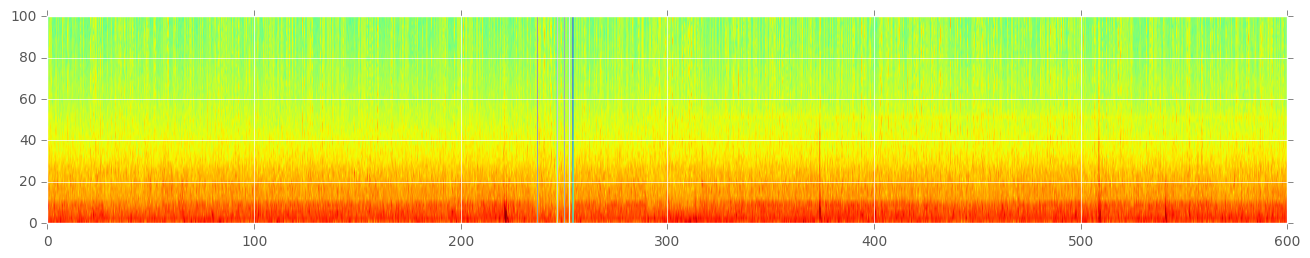

In [28]:
spec = spectral.spectrogram(d1, nchunk=nchunk, windowStep=windowStep, absLog=1, alpha=0.5, window='hann')
spectral.spec_to_fig(spec, 'd1.png')

In [30]:
n = 6000
b0 = d0[:n]
b1 = d1[:n]

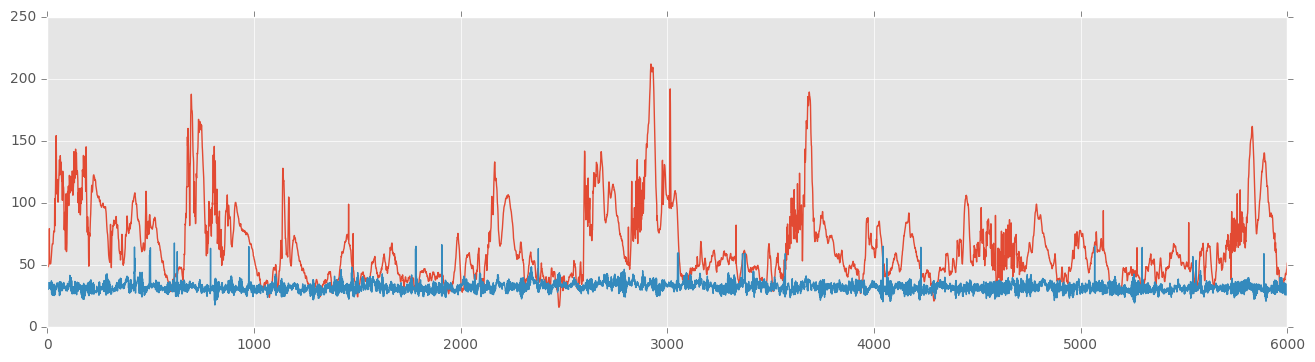

In [35]:
plt.plot(np.std(b0, axis=1))
plt.plot(np.std(b1, axis=1))

In [40]:
reload(metrics)

<module 'eegkaggle.msignal.metrics' from 'eegkaggle/msignal/metrics.py'>

In [41]:
print(np.std(np.std(b0, axis=1)), np.std(np.std(b1, axis=1)))
print(metrics.chanstd(b0), metrics.chanstd(b1))

29.8307 4.23507
29.8307 4.23507


In [37]:
print(np.std(np.std(d0, axis=1)), np.std(np.std(d1, axis=1)))

30.0919 8.80825


In [39]:
print(metrics.rms(np.std(d0, axis=1)), metrics.rms(np.std(d1, axis=1)))

63.0483 41.0849
